In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import gc
import random
import tqdm.notebook as tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio

from torch.utils.tensorboard import SummaryWriter
from tensorboard.backend.event_processing import event_accumulator

from transformers import (
    AutoFeatureExtractor,
    ASTForAudioClassification
)

from utils import compute_score, train

%matplotlib inline

In [2]:
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED) 
    torch.manual_seed(SEED) 
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  
    os.environ['PYTHONHASHSEED'] = str(SEED)
set_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Просмотр данных и формирование датасета

In [4]:
DIR_TRAIN = "wavs/train_"
DIR_VAL = "wavs/val_"
DIR_TEST = "wavs/test_"

PATH_TRAIN = "train.csv"
PATH_VAL = "val.csv"
PATH_TEST = "test.csv"

df_train = pd.read_csv(PATH_TRAIN)
df_val = pd.read_csv(PATH_VAL)
df_test = pd.read_csv(PATH_TEST)

print("В обучающей выборке {} аудиозаписей".format(len(df_train)))
print("В валидационной выборке {} аудиозаписей".format(len(df_val)))
print("В тестовой выборке {} аудиозаписей".format(len(df_test)))

В обучающей выборке 9321 аудиозаписей
В валидационной выборке 815 аудиозаписей
В тестовой выборке 833 аудиозаписей


In [5]:
class EmotionDataset(Dataset):
    def __init__(self, train_df, val_df, test_df):
        """
        Аргументы:
            train_df, val_df, test_df (pd.DataFrame): тренировочный, валидационный и тестовый наборы данных
        """
        
        self.train_df = train_df
        self.train_size = len(self.train_df)
        
        self.val_df = val_df
        self.val_size = len(self.val_df)
        
        self.test_df = test_df
        self.test_size = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.val_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train') 
    
    @classmethod
    def load_dataset(cls, path_train, path_val, path_test, features_dir=None, 
                     dir_train=None, dir_val=None, dir_test=None,
                     feature_extractor=None, load_features=True, save_features=False):
        """Загрузка данных датасета
        Аргументы:
            path_train, path_val, path_test (str): пути к тренировочному, валидационному и тестовому наборам данных
            features_dir (str): директория признаков аудиозаписей
            dir_train, dir_val, dir_test (str): директории с аудиозаписями
            feature_extractor (): объект класса, извлекающего признаки из аудиозаписи
            load_features (bool): True -> загрузка выделенных ранее признаков, 
                                  False -> выделение признаков из аудиозаписей
            save_featurees (bool): True -> сохранение выделенных признаков в features_dir
        Возвращает:
            экземпляр EmotionDataset
        """
        #загрузка данных
        train_df = pd.read_csv(path_train)
        val_df = pd.read_csv(path_val)
        test_df = pd.read_csv(path_test)
        
        #загрузка признаков
        if load_features:
            features = cls._load_features(train_df, 'train', features_dir)
            train_df.insert(len(train_df.columns), 'features', features)

            features = cls._load_features(val_df, 'val', features_dir)
            val_df.insert(len(val_df.columns), 'features', features)

            features = cls._load_features(test_df, 'test', features_dir)
            test_df.insert(len(test_df.columns), 'features', features)
        
        #векторизация аудиозаписей и сохранение признаков
        else:
            
            features = cls._extract_features(train_df, dir_train, feature_extractor,
                                             'train', features_dir, save_features)
            train_df.insert(len(train_df.columns), 'features', features)

            features = cls._extract_features(val_df, dir_val, feature_extractor, 
                                             'val', features_dir, save_features)
            val_df.insert(len(val_df.columns), 'features', features)
            
            features = cls._extract_features(test_df, dir_test, feature_extractor, 
                                             'test', features_dir, save_features)
            test_df.insert(len(test_df.columns), 'features', features)
        
        return cls(train_df, val_df, test_df)
    
    def _extract_features(df, files_dir, feature_extractor, mode, features_dir=None, save_features=False):
        """Выделение признаков
        """
        features = []
        pbar = tqdm.tqdm(range(len(df['hash_id'])), total=len(df['hash_id']))
        pbar.set_description(mode + ' dataset loading')
        for i in pbar:
            waveform, sampling_rate = torchaudio.load(files_dir + df['audio_path'][i])
            waveform = waveform.squeeze().numpy()
            feature = feature_extractor(waveform, sampling_rate).input_values[0]
            features.append(feature)
            if save_features:
                np.save('{0}{1}/{2}.npy'.format(features_dir, mode, df['hash_id'][i]), feature)
        return features
    
    def _load_features(df, mode, features_dir):
        """Загрузка ранее выделенных признаков
        """
        features = []
        pbar = tqdm.tqdm(range(len(df['hash_id'])), total=len(df['hash_id']))
        pbar.set_description(mode + ' dataset loading')
        for i in pbar:
            feature = np.load('{0}{1}/{2}.npy'.format(features_dir, mode, df['hash_id'][i]))
            features.append(feature)
        return features
        
    def set_split(self, split="train"):
        """Выбор фрагментов набора данных по столбцу из объекта dataframe
        Аргументы:
            split (str): "train"/"val"/"test"
        """
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[self._target_split]

    def __getitem__(self, idx):
        row = self._target_df.iloc[idx]
        return {"features": row['features'],
                "class": row['emotion']}

    def __len__(self):
        return self._target_size

## Дообучение Audio Spectrogram Transformer (AST)

In [6]:
MODEL_PATH = "MIT/ast-finetuned-audioset-10-10-0.4593"
CLASSES = ['positive', 'sad', 'angry', 'neutral']
DIR_FEATURES = 'ast_features/'
EXPERIMENT_DIR = 'ast_experiments/'

In [ ]:
auto_feature_extractor = AutoFeatureExtractor.from_pretrained(MODEL_PATH)
feature_extractor = lambda waveform, sampling_rate: auto_feature_extractor(waveform, sampling_rate=sampling_rate, 
                                                                           return_tensors="np")
ds = EmotionDataset.load_dataset(PATH_TRAIN, PATH_VAL, PATH_TEST, features_dir=DIR_FEATURES,
                                 #dir_train=DIR_TRAIN, dir_val=DIR_VAL, dir_test=DIR_TEST, 
                                 #feature_extractor = feature_extractor, load_features=False, save_features=True)
                                 feature_extractor = feature_extractor, load_features=True)
                                 

In [45]:
def experiment_plots(exp_nums, loss_ylim, score_ylim):
    def load_data(data_dir):
        ea_file = os.listdir(data_dir)[0]
        ea=event_accumulator.EventAccumulator('{}/{}'.format(data_dir, ea_file)) 
        ea.Reload()
        return [item.value for item in ea.scalars.Items(ea.scalars.Keys()[-1])][:5]
    
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(12, 25))
    x = np.arange(5) + 1

    ax[0, 0].set(title='Train Loss', ylabel='loss', xlabel='epoch', ylim=loss_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/loss_train'.format(exp_num))
        ax[0, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[0, 0].legend()
    ax[0, 0].grid()

    ax[0, 1].set(title='Validation Loss', ylabel='loss', xlabel='epoch', ylim=loss_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/loss_validation'.format(exp_num))
        ax[0, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[0, 1].legend()
    ax[0, 1].grid()
    
    ax[1, 0].set(title='Accuracy (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/accuracy_macro_average_validation'.format(exp_num))
        ax[1, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[1, 0].legend()
    ax[1, 0].grid()
    
    ax[1, 1].set(title='F1 (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_macro_average_validation'.format(exp_num))
        ax[1, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[1, 1].legend()
    ax[1, 1].grid()
    
    ax[2, 0].set(title='Precision (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/precision_macro_average_validation'.format(exp_num))
        ax[2, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[2, 0].legend()
    ax[2, 0].grid()
    
    ax[2, 1].set(title='Recall (macro)', ylabel='score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/recall_macro_average_validation'.format(exp_num))
        ax[2, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[2, 1].legend()
    ax[2, 1].grid()
    
    ax[3, 0].set(title='Positive', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_positive_validation'.format(exp_num))
        ax[3, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[3, 0].legend()
    ax[3, 0].grid()
    
    ax[3, 1].set(title='Sad', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_sad_validation'.format(exp_num))
        ax[3, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[3, 1].legend()
    ax[3, 1].grid()
    
    ax[4, 0].set(title='Angry', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_angry_validation'.format(exp_num))
        ax[4, 0].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[4, 0].legend()
    ax[4, 0].grid()
    
    ax[4, 1].set(title='Neutral', ylabel='f1 score', xlabel='epoch', ylim=score_ylim, xticks=x)
    for exp_num in exp_nums:
        data = load_data('ast_experiments/runs/exp{}/f1_neutral_validation'.format(exp_num))
        ax[4, 1].plot(x, data, label='exp{}'.format(exp_num), lw=2)
    ax[4, 1].legend()
    ax[4, 1].grid()

    plt.show()

### 1. Дообучение всей сети (трансформер + классификатор)

#### 1.1 Одинаковое изменение lr для всех параметров сети в процессе обучения

Гиперпараметры эксперимента:
- optimizer: Adam
- batch_size: 8
- scheduler: после 2 эпохи lr уменьшается в 2 раза каждую эпоху
- base_lr: 1e-5, 1e-6

In [ ]:
# Experiment 1

EPOCH = 10
BATCH_SIZE = 2
SEED = 42
EXP_NUM = 1 #1

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)#, momentum=0.9)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=4)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 2

EPOCH = 5
BATCH_SIZE = 2
SEED = 42
EXP_NUM = 2 #13

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-6)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=4)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

#### 1.2 Разное изменение lr в процессе обучения для всех параметров трансформера и параметров классификатора

Гиперпараметры эксперимента:
- optimizer: 
    - для трансформера: Adam
    - для классификатора: AdamW
- batch_size: 12
- scheduler: 
    - для трансформера: после 2 эпохи lr уменьшается в 2 раза каждую эпоху
    - для классификатора: постоянный lr
- base_lr: 1e-5, 1e-6

In [ ]:
# Experiment 3

EPOCH = 5
BATCH_SIZE = 3
SEED = 42
EXP_NUM = 3 #14

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = [optim.Adam(model.audio_spectrogram_transformer.parameters(), lr=1e-5),
             optim.AdamW(model.classifier.parameters(), lr=1e-5)
            ]
sсheduler = [optim.lr_scheduler.MultiStepLR(optimizer[0], milestones=np.arange(2, EPOCH), gamma=0.5),
             optim.lr_scheduler.MultiStepLR(optimizer[1], milestones=[EPOCH + 1])
            ]

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=4)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 4

EPOCH = 5
BATCH_SIZE = 3
SEED = 42
EXP_NUM = 4 #15

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)
model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = [optim.Adam(model.audio_spectrogram_transformer.parameters(), lr=1e-6),
             optim.AdamW(model.classifier.parameters(), lr=1e-6)
            ]
sсheduler = [optim.lr_scheduler.MultiStepLR(optimizer[0], milestones=np.arange(2, EPOCH), gamma=0.5),
             optim.lr_scheduler.MultiStepLR(optimizer[1], milestones=[EPOCH + 1])
            ]

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=4)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

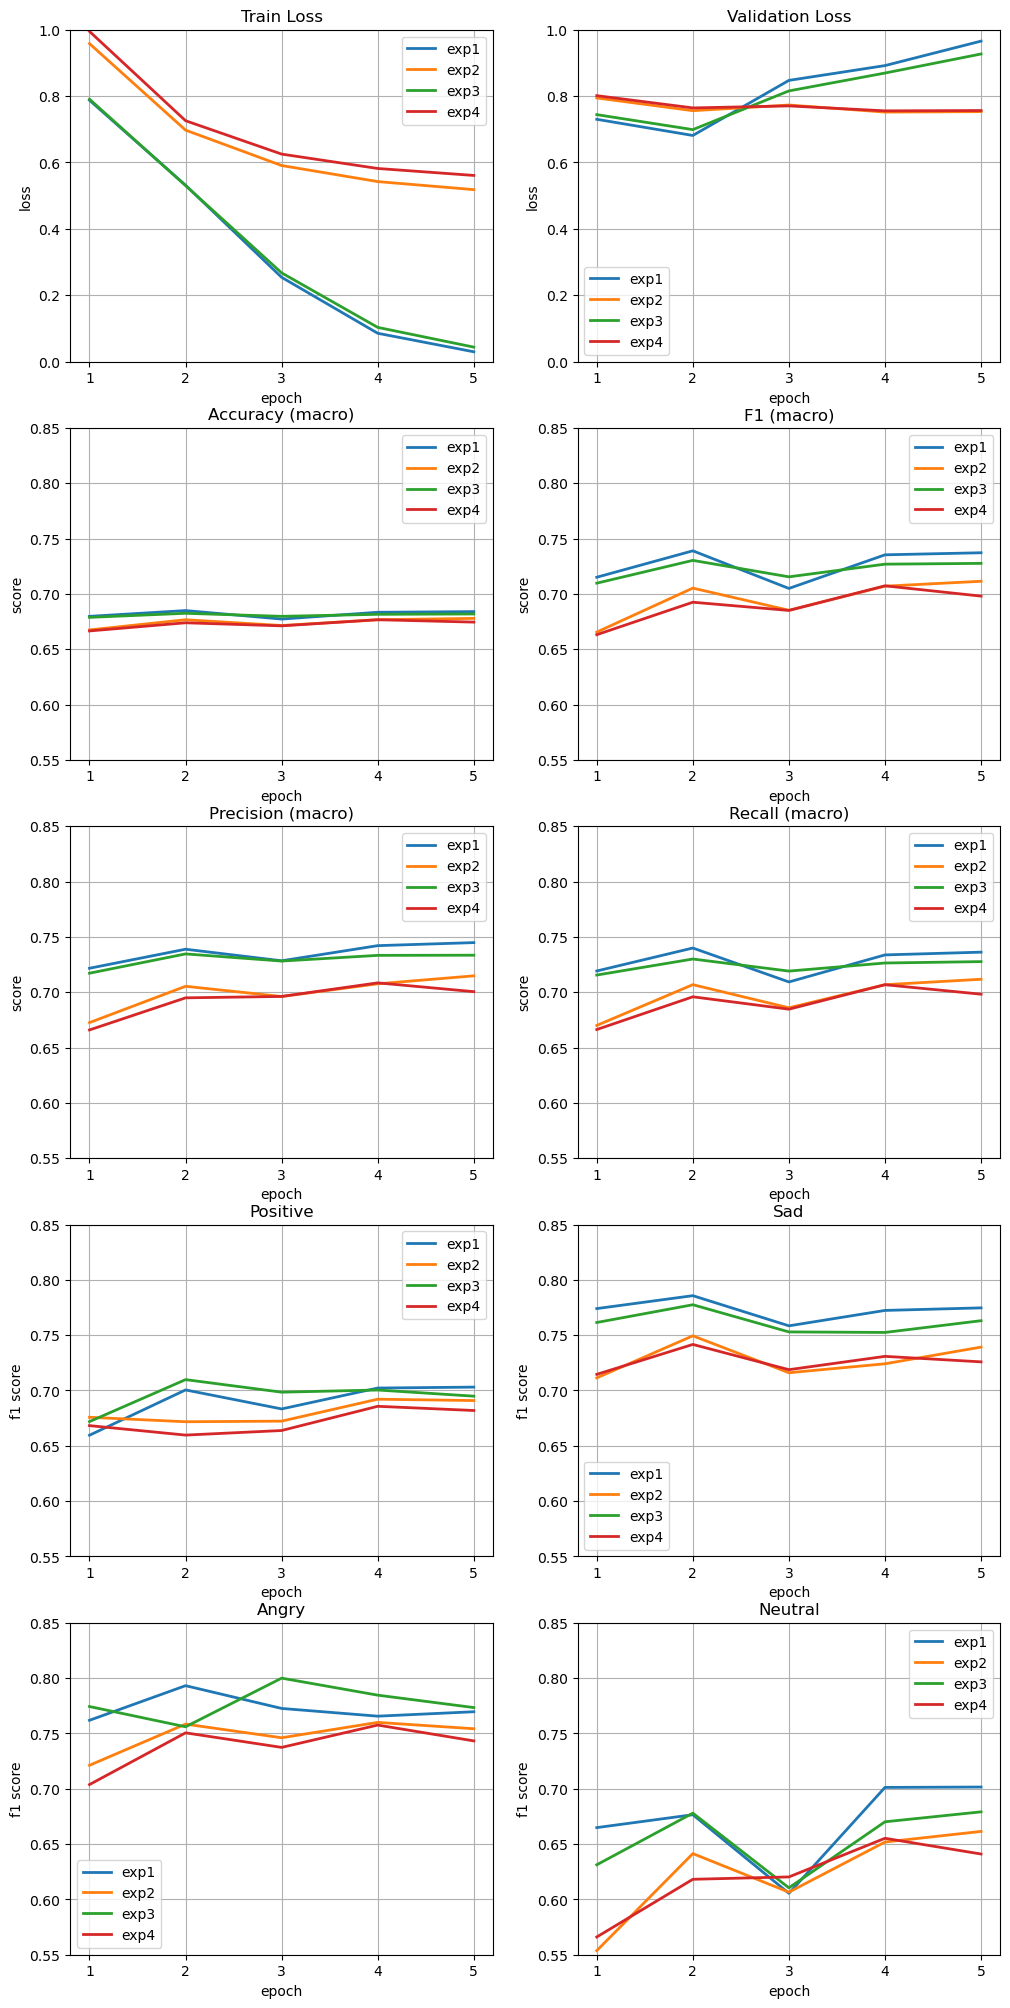

In [80]:
experiment_plots([1, 2, 3, 4], loss_ylim=[0, 1], score_ylim=[0.55, 0.85])

Стабильное обучение с наибольшими итоговыми значениями метрик на валидационной выборке показывает модель эксперимента 2 с данными гиперпараметрами:

- optimizer: Adam,
- batch_size: 8,
- scheduler: после 2 эпохи lr уменьшается в 2 раза каждую эпоху,
- base_lr: 1e-6.

Гиперпараметр `base_lr = 1e-5` (эксперименты 1 и 3) приводит к переобучению модели (значение потерь начинает расти после 2 эпози обучения).

### 2. Обучение классификатора

#### 2.1 Уменьшение lr в 2 раза каждую эпоху после 2 эпохи обучения (Adam)

Гиперпараметры эксперимента:
- optimizer: Adam (оптимизация параметров классификатора)
- batch_size: 12
- scheduler: после 2 эпохи lr уменьшается в 2 раза каждую эпоху
- base_lr: 1e-5, 1e-2, 5e-2, 1e-1

In [ ]:
# Experiment 5

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 5 #2

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-5)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 6

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 6 #3

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 7

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 7 #4

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=5e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 8

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 8 #5

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-1)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

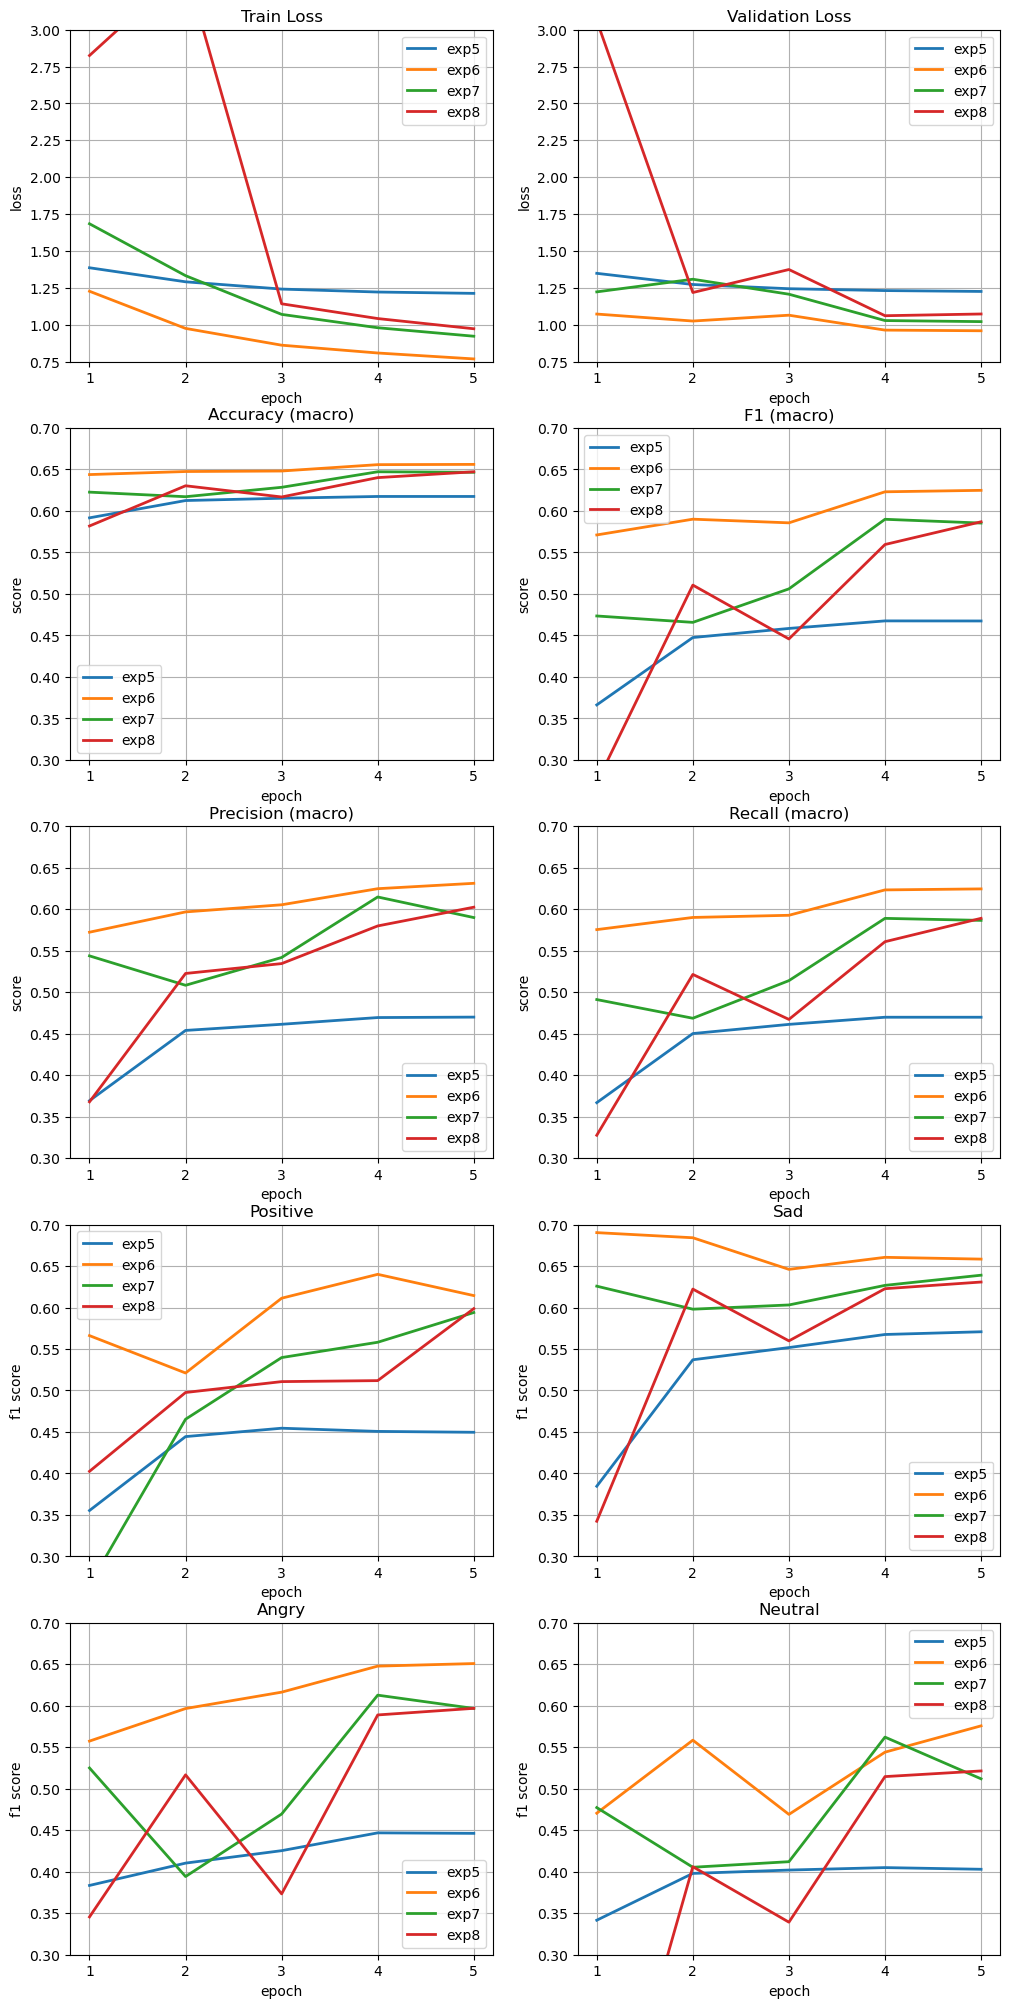

In [81]:
experiment_plots([5, 6, 7, 8], loss_ylim=[0.75, 3], score_ylim=[0.3, 0.7])

Стабильное обучение с наибольшими итоговыми значениями метрик на валидационной выборке показывает модель с параметром `lr = 1e-2` (эксперимент 6).

#### 2.2 Уменьшение lr в 2 раза каждую эпоху после 2 эпохи обучения (AdamW)

Гиперпараметры эксперимента:
- optimizer: AdamW (оптимизация параметров классификатора)
- batch_size: 12
- scheduler: после 2 эпохи lr уменьшается в 2 раза каждую эпоху
- base_lr: 1e-2

In [ ]:
# Experiment 9

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 9 #6

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

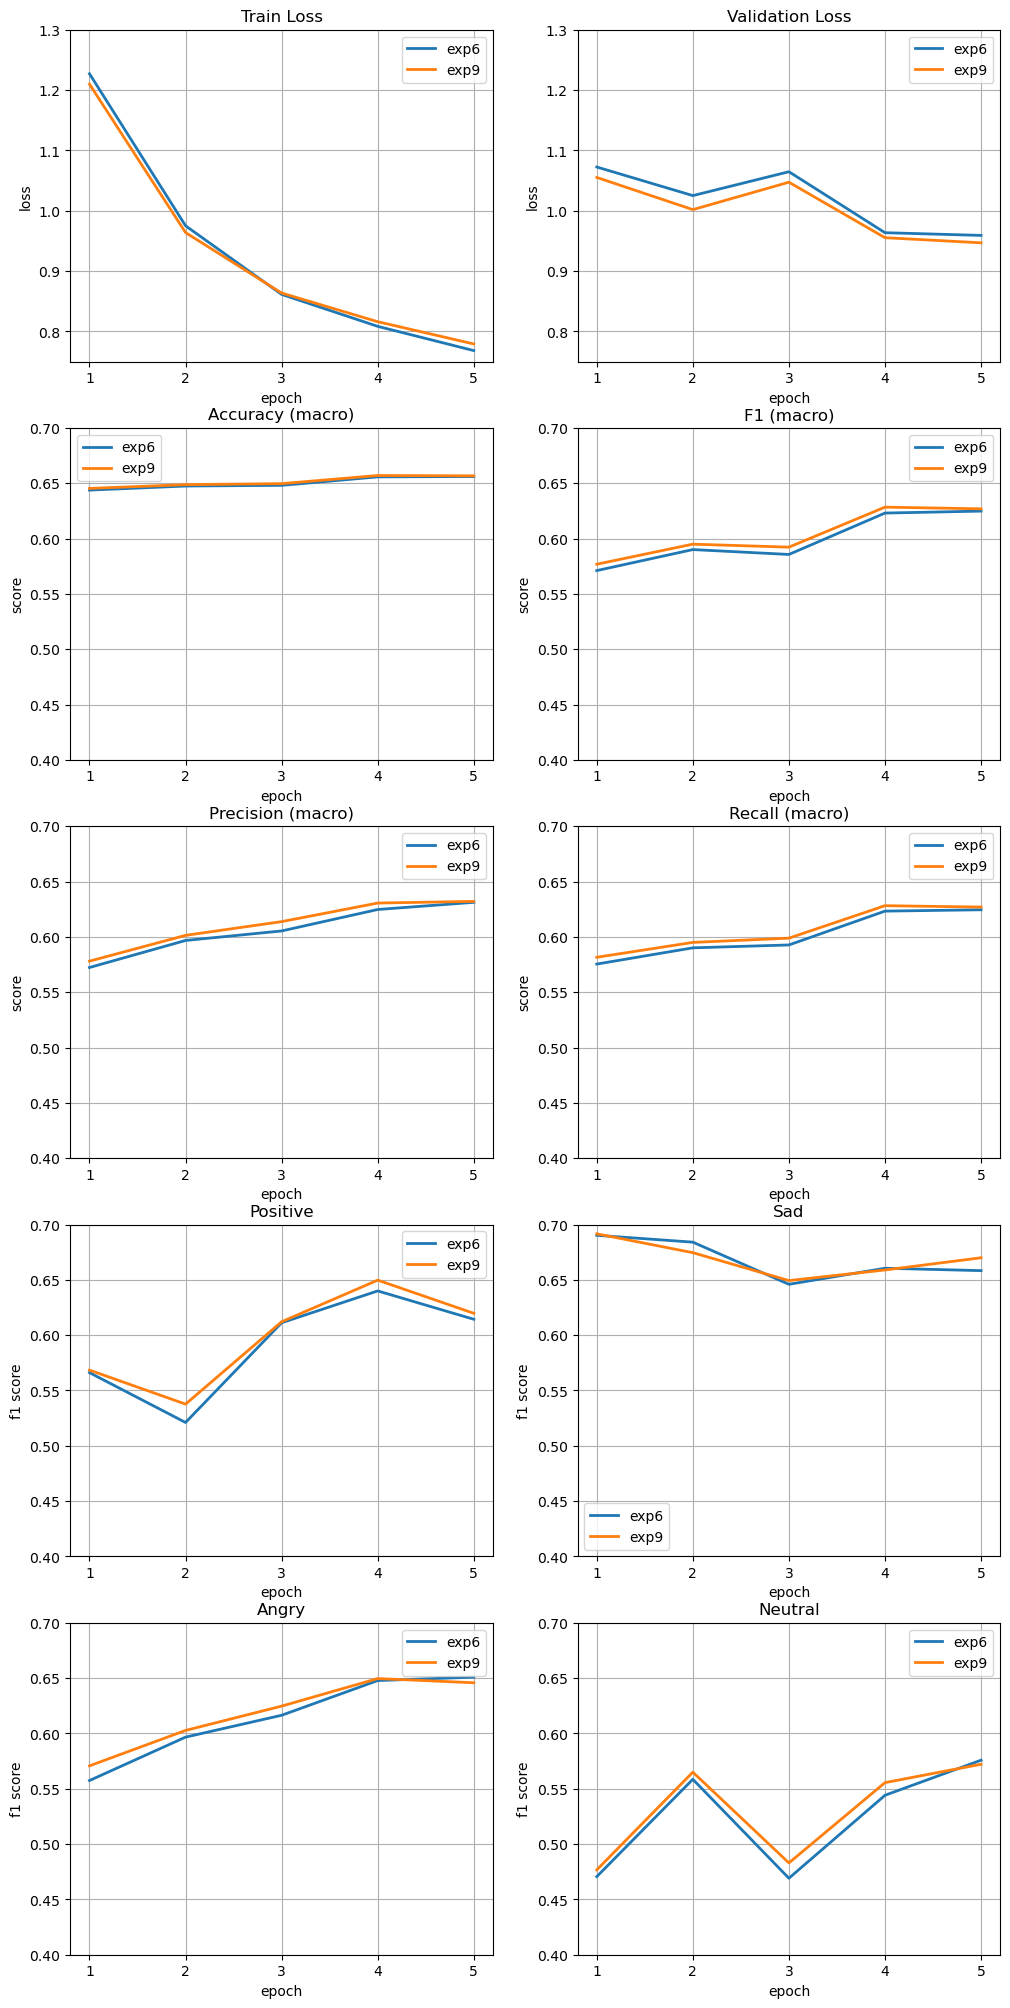

In [82]:
experiment_plots([6, 9], loss_ylim=[0.75, 1.3], score_ylim=[0.4, 0.7])

Результат обучения модели в эксперименте 9 показан в сравнении с результатом эксперимента 6, отобранного в предыдущей группе экспериентов (2.1). 

На построенных графиках заметных различий в значениях потерь и метриках при использовании оптимизатора AdamW, в сравнении с Adam.

#### 2.3 Постоянный lr

Гиперпараметры эксперимента:
- optimizer: Adam, AdamW (оптимизация параметров классификатора)
- batch_size: 12
- scheduler: постоянный lr
- base_lr: 1e-2

In [ ]:
# Experiment 10

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 10 #7

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[EPOCH + 1], gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 11

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 11 #8

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=1e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[EPOCH + 1], gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

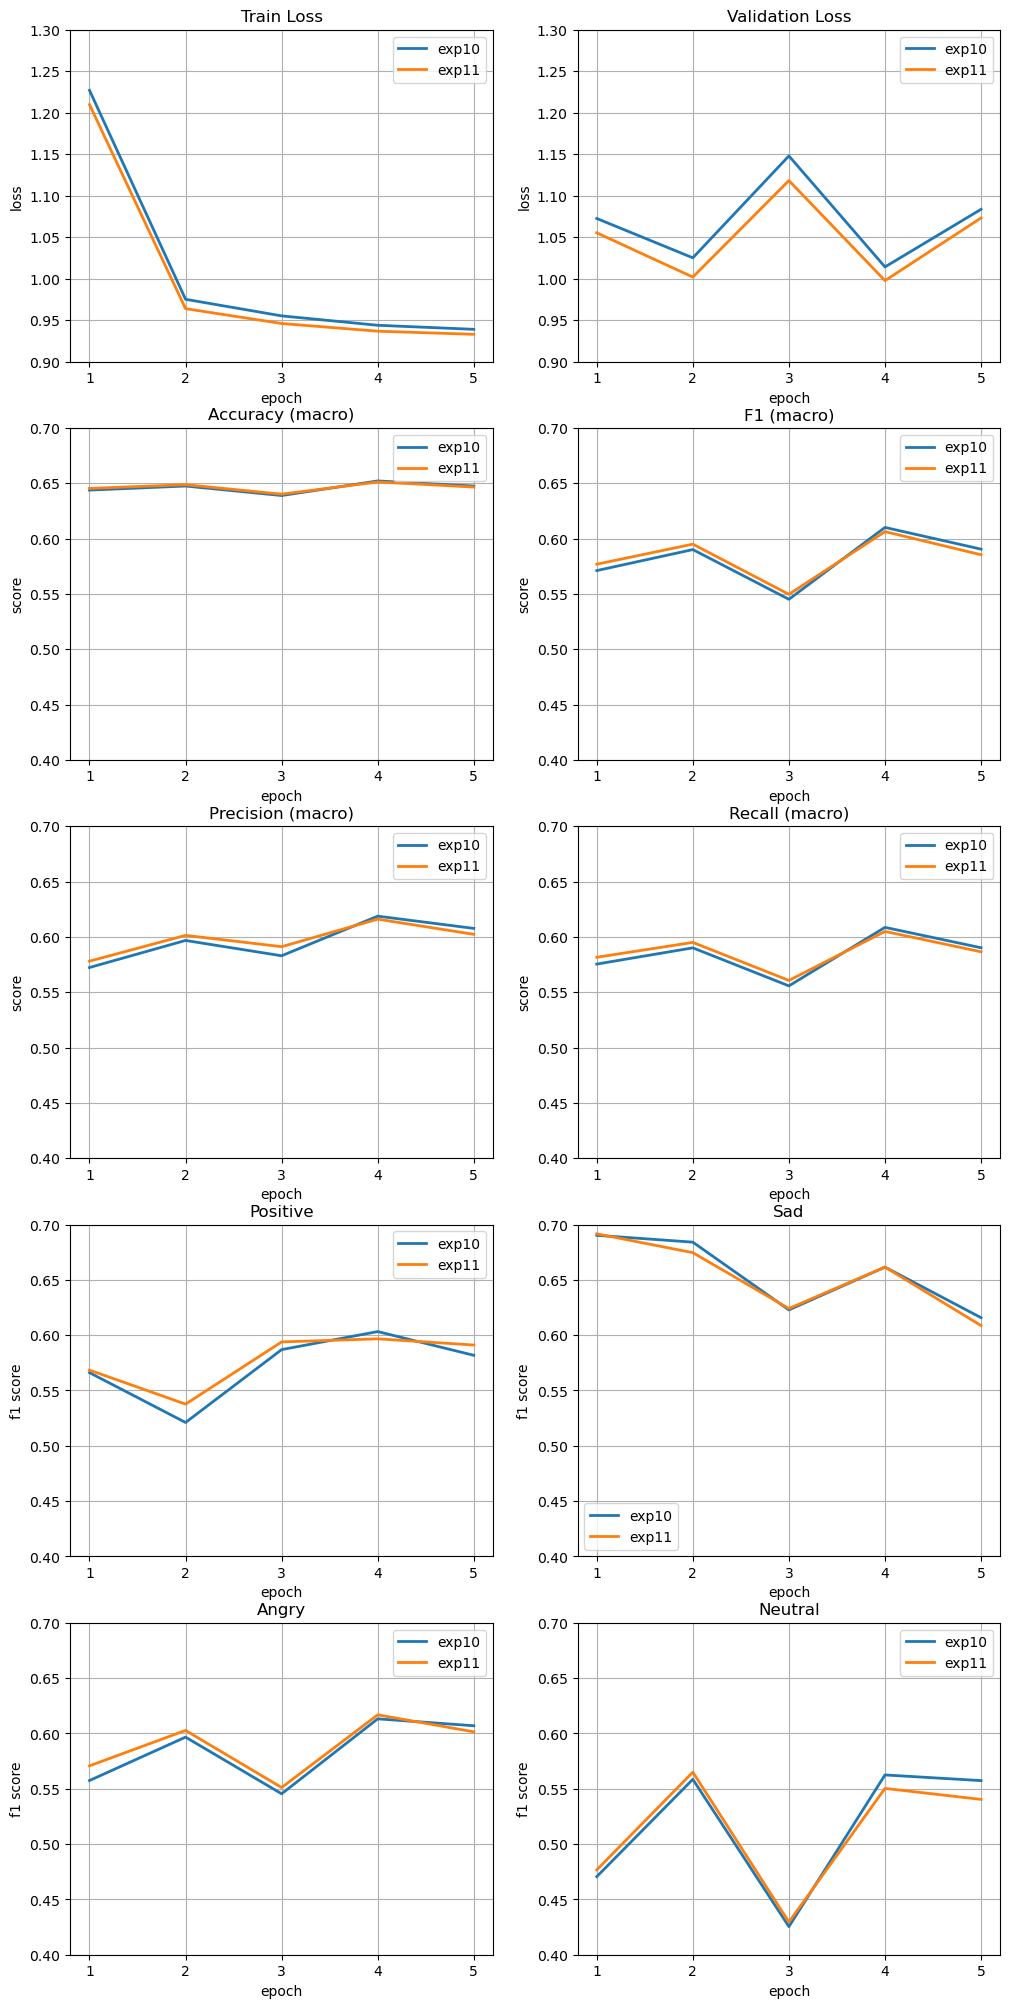

In [83]:
experiment_plots([10, 11], loss_ylim=[0.9, 1.3], score_ylim=[0.4, 0.7])

Аналагочно предыдущей группе экспериментов (2.2), заметных различий при использовании оптимизаторов Adam и AdamW нет.

#### 2.4 Уменьшение lr в 2 раза каждую 2-ую эпоху после 2 эпохи обучения

Гиперпараметры эксперимента:
- optimizer: Adam (оптимизация параметров классификатора)
- batch_size: 12
- scheduler: после 2 эпохи lr уменьшается в 2 раза каждую 2-ую эпоху
- base_lr: 1e-2, 1e-1

In [ ]:
# Experiment 12

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 12 #9

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH, 2), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 13

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 13 #10

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-1)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH, 2), gamma=0.5)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

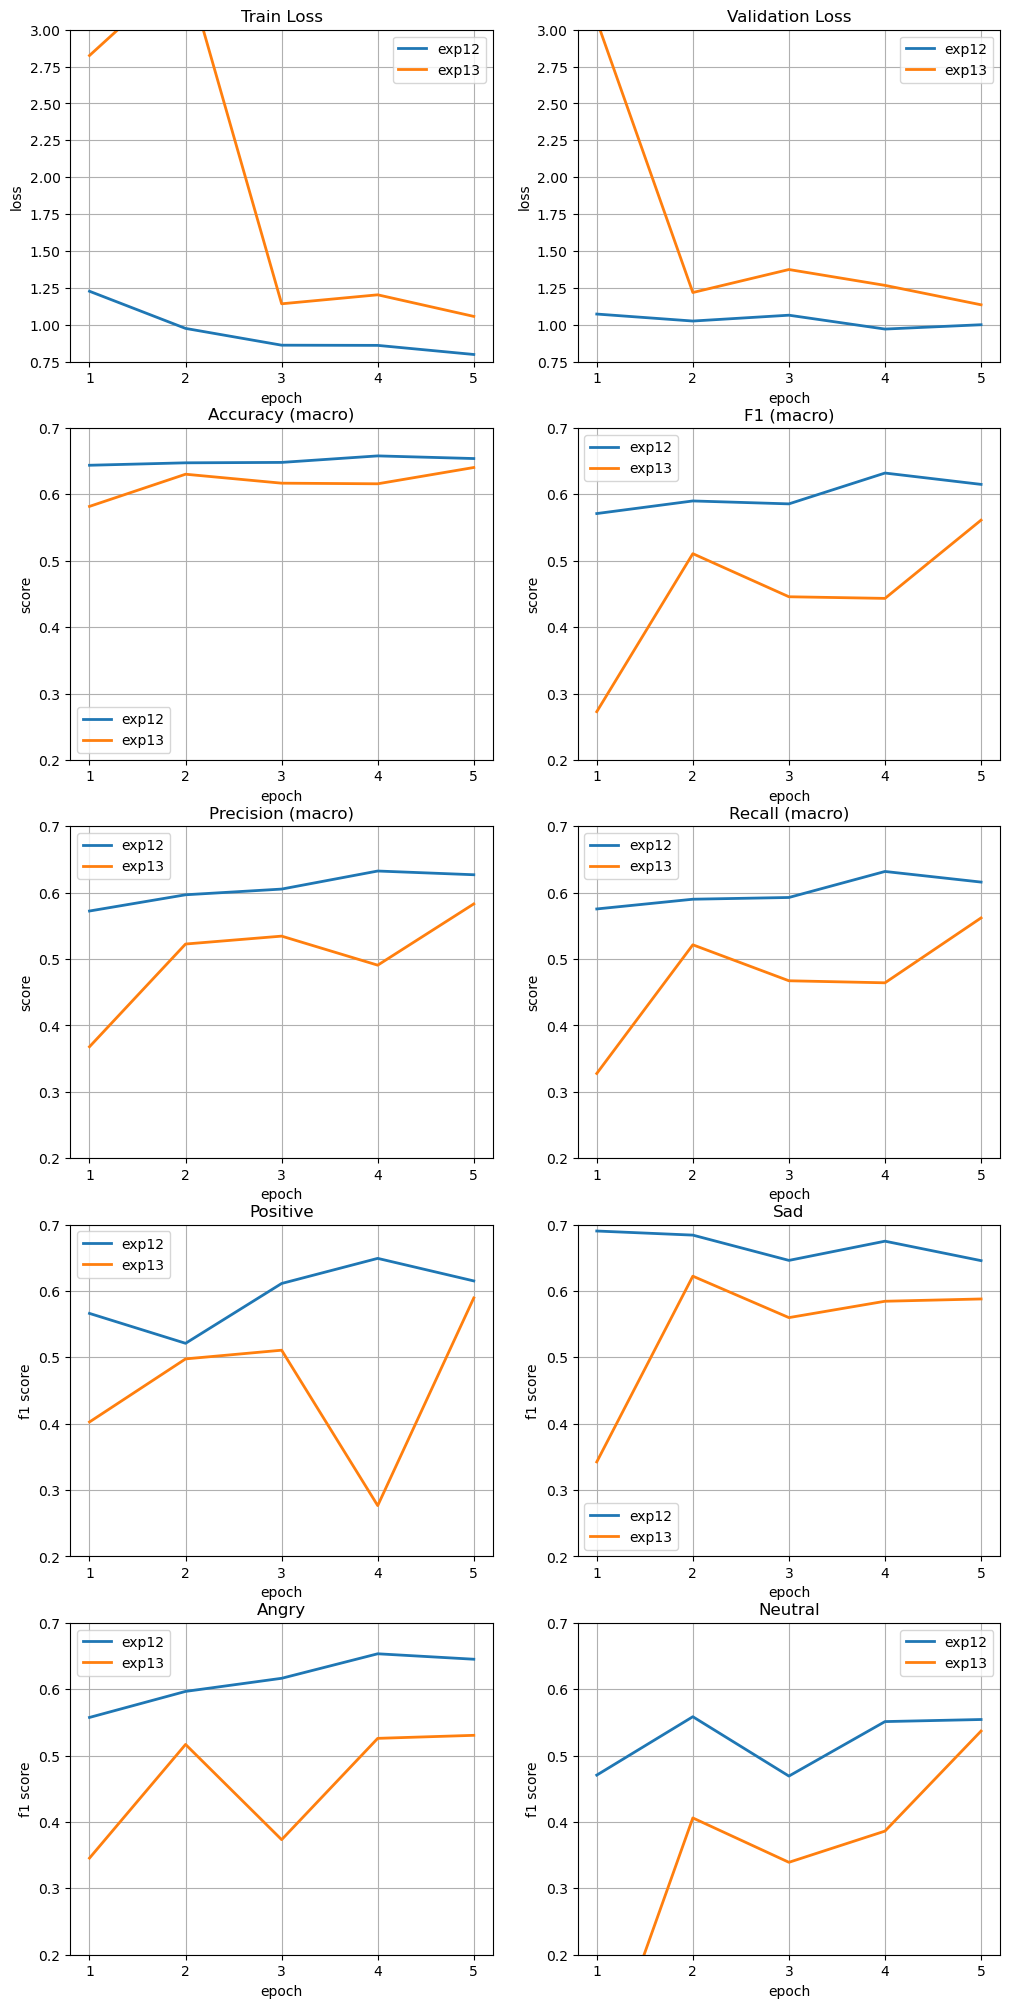

In [84]:
experiment_plots([12, 13], loss_ylim=[0.75, 3], score_ylim=[0.2, 0.7])

При использовании `base_lr = 1e-2` (эксперимент 12) получены более стабильные результаты и высокие значения метрик.

#### 2.5 Уменьшение lr на четверть каждую эпоху после 2 эпохи обучения

Гиперпараметры эксперимента:
- optimizer: Adam (оптимизация параметров классификатора)
- batch_size: 12
- scheduler: после 2 эпохи lr уменьшается на 1/4 каждую эпоху
- base_lr: 1e-2, 5e-1

In [ ]:
# Experiment 14

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 14 #11

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-2)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.75)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Experiment 15

EPOCH = 5
BATCH_SIZE = 12
SEED = 42
EXP_NUM = 15 #12

set_seed(SEED)
    
model = ASTForAudioClassification.from_pretrained(MODEL_PATH, num_labels=len(CLASSES), 
                                                  return_dict=False, ignore_mismatched_sizes=True)

for param in model.audio_spectrogram_transformer.parameters():
    param.requires_grad = False

model.to(device)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=5e-1)
sсheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.arange(2, EPOCH), gamma=0.75)

writer =  SummaryWriter("{0}runs/exp{1}".format(EXPERIMENT_DIR, EXP_NUM))
writer.add_graph(model, input_to_model=torch.Tensor(np.array([ds[i]['features'] 
                                                              for i in range(BATCH_SIZE)])).to(device, torch.float32))

train(model, ds, loss_func, optimizer, sсheduler, EPOCH, BATCH_SIZE, device, writer, CLASSES,
      "{0}checkpoints/exp{1}".format(EXPERIMENT_DIR, EXP_NUM), gradient_accumulation_steps=1)

writer.flush()
writer.close()

gc.collect()
torch.cuda.empty_cache()

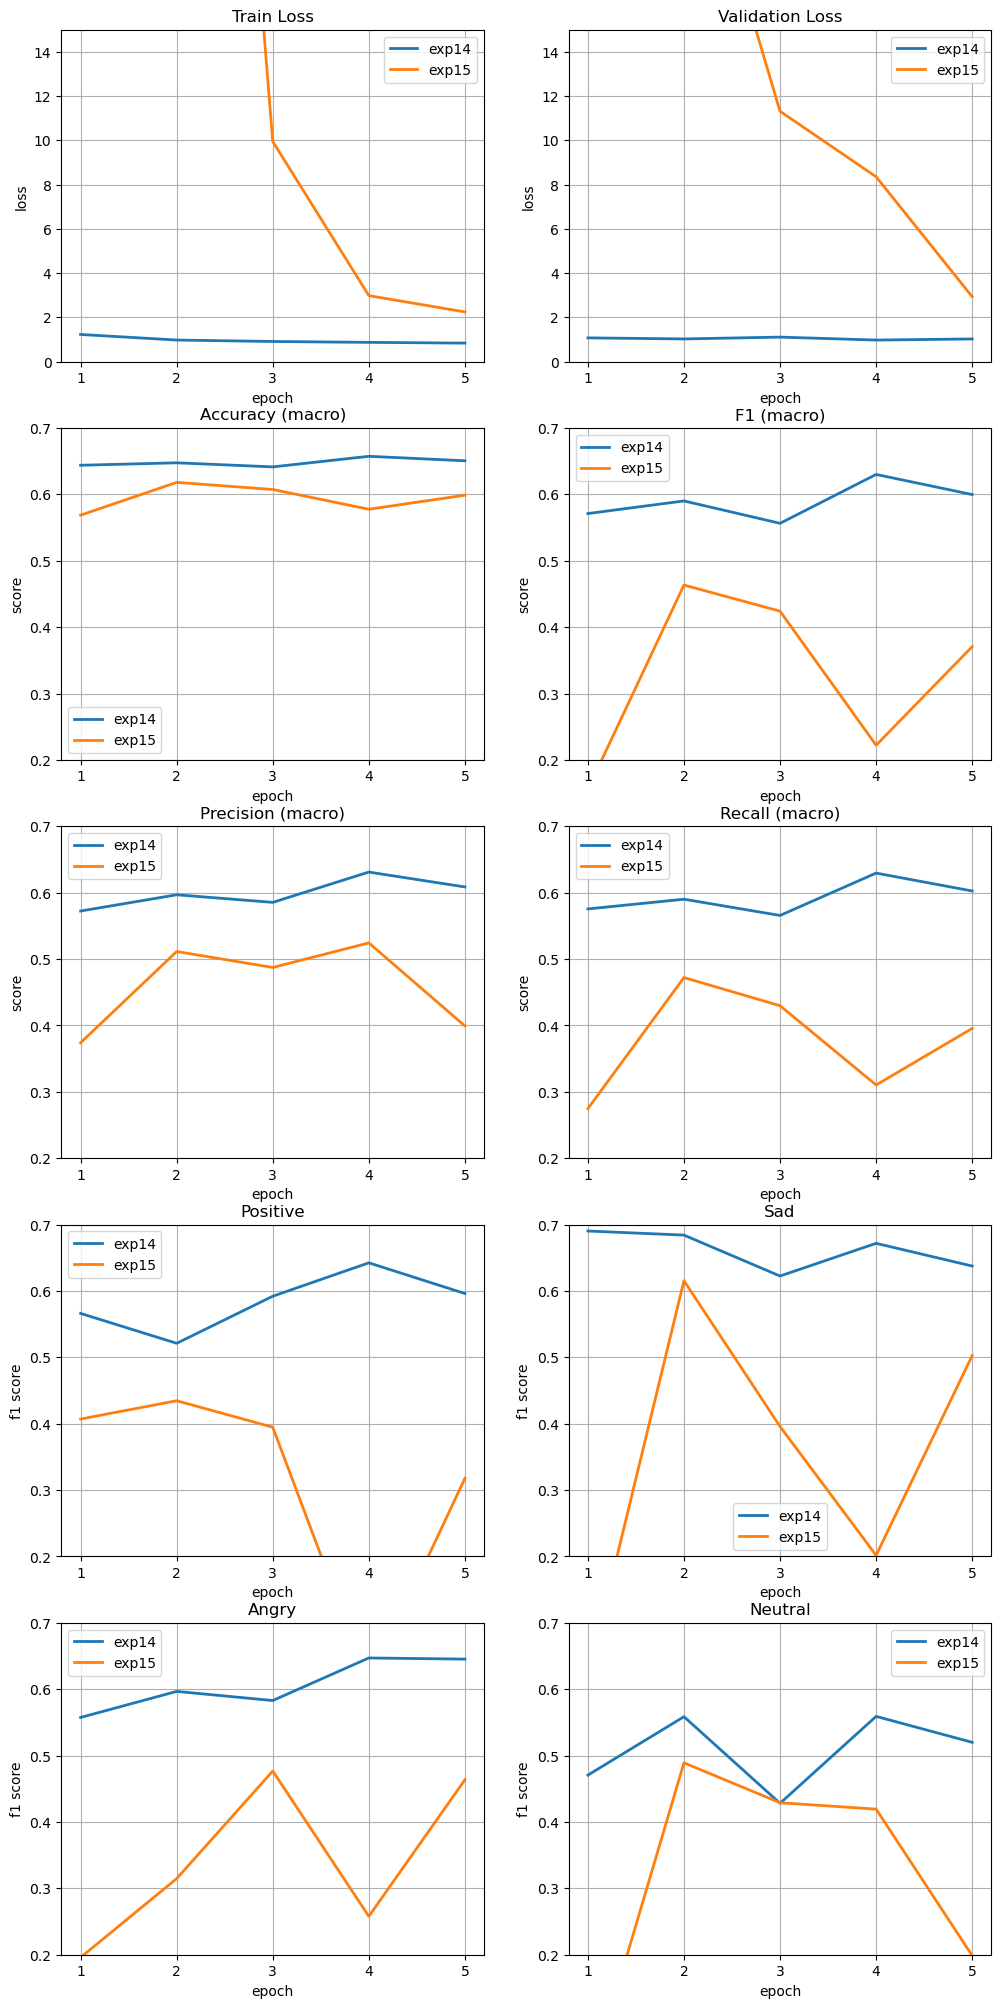

In [85]:
experiment_plots([14, 15], loss_ylim=[0, 15], score_ylim=[0.2, 0.7])

При использовании `base_lr = 1e-2` (эксперимент 14) получены более стабильные результаты и высокие значения метрик.

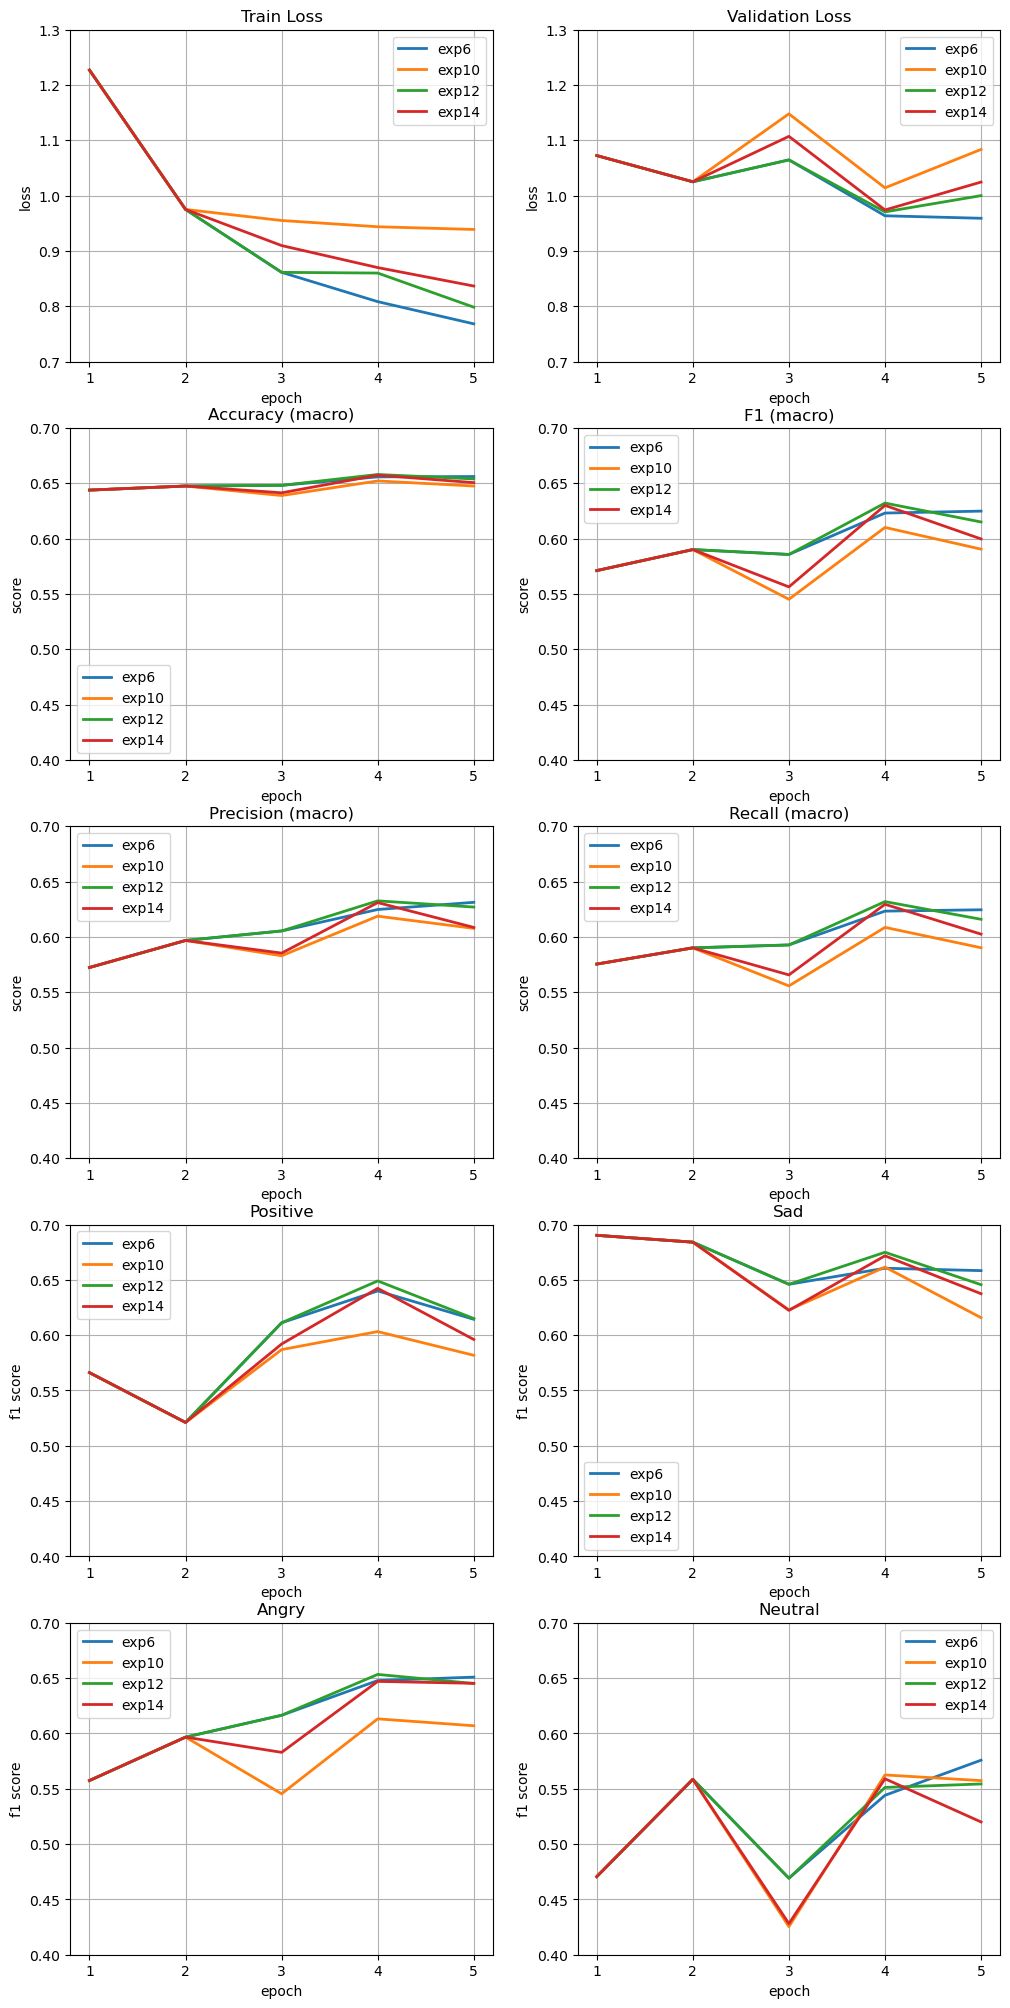

In [94]:
experiment_plots([6, 10, 12, 14], loss_ylim=[0.7, 1.3], score_ylim=[0.4, 0.7])

В группе экспериментов по обучению только классификатора модели (2) наиболее стабильные результаты показала модель, обученная в эксперименте 6.

### Результаты

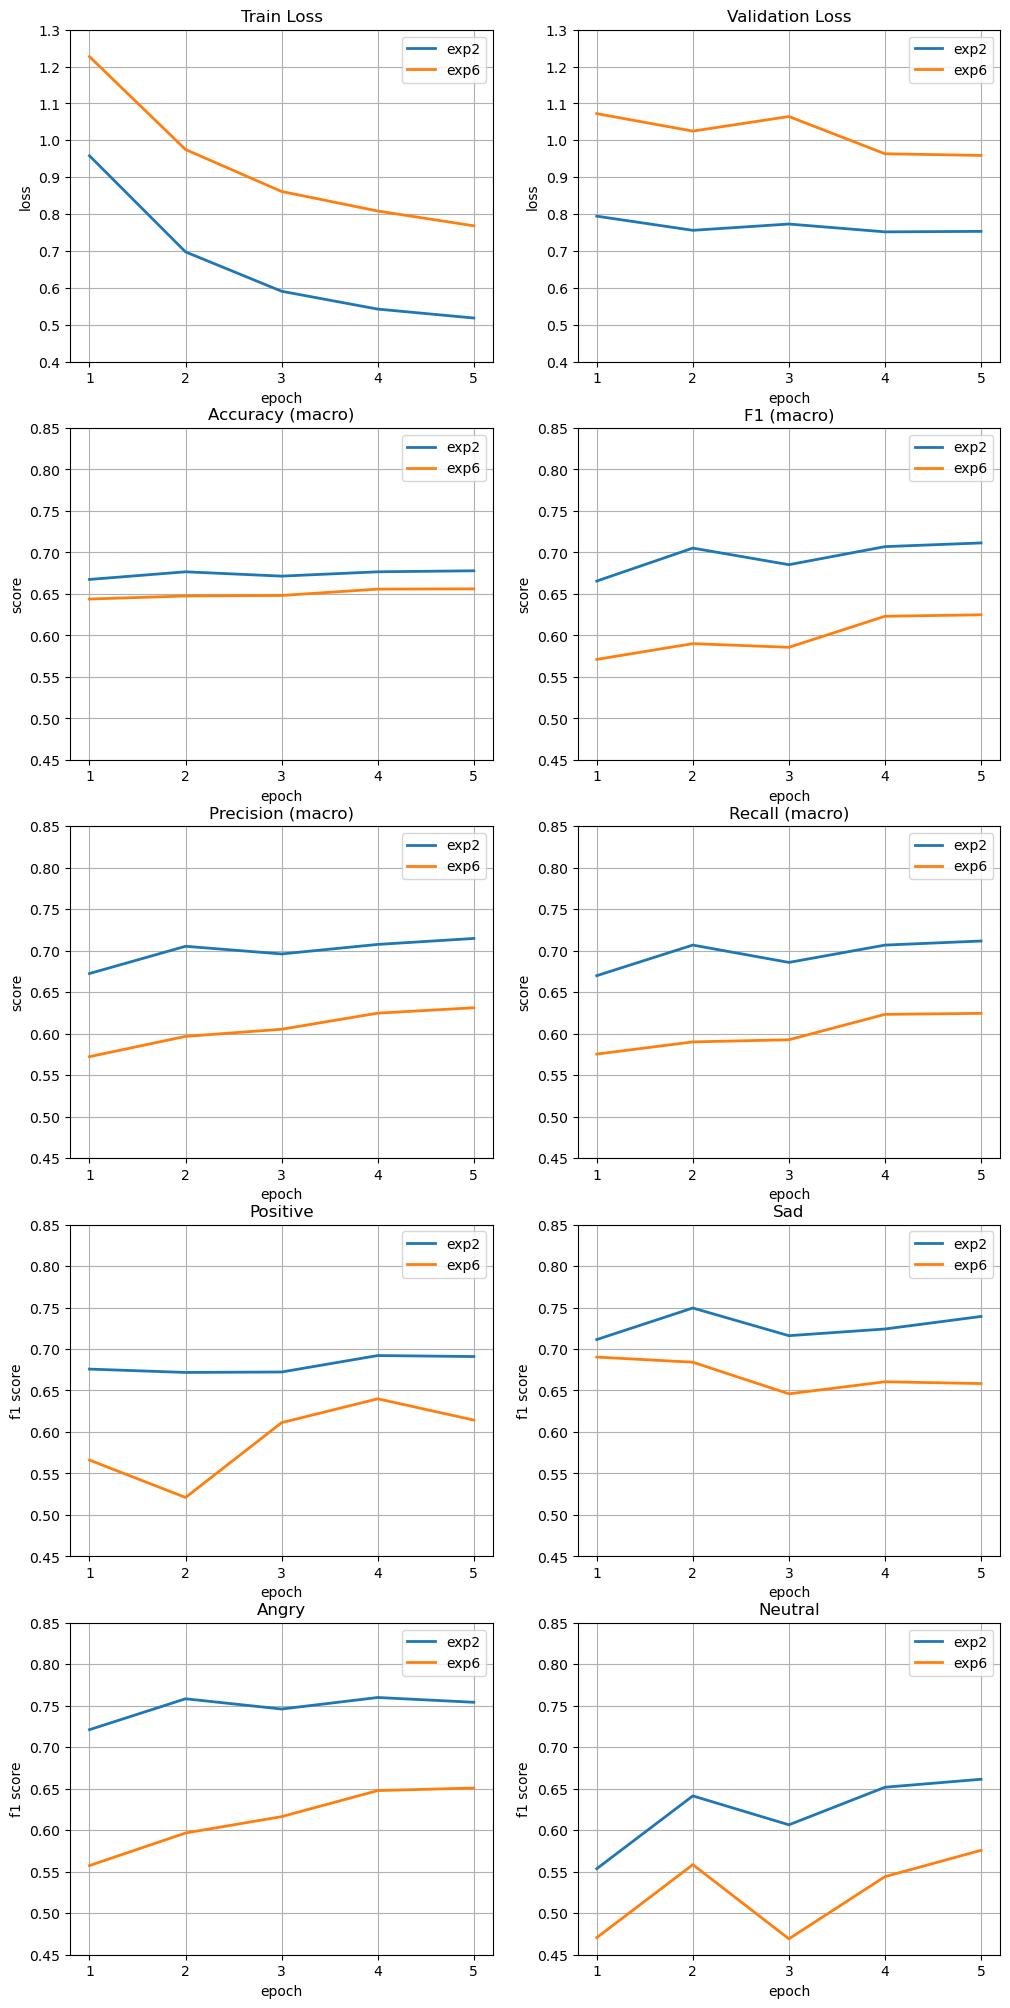

In [98]:
experiment_plots([2, 6], loss_ylim=[0.4, 1.3], score_ylim=[0.45, 0.85])